# Mountain Car VAE

In [1]:
%matplotlib inline
# notebook stuff
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

# numpy
import numpy as np
from PIL import Image

# torch stuff
import torch
import torch.nn as nn
from torchvision.transforms import Compose, ToTensor, ToPILImage
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from torchsummary import summary

# our stuff
from constants import *

import importlib
import model.vaelin
VAELin = importlib.reload(model.vaelin).VAELin
from dataset import VAEDataset
from resample_vae import VAEResampler

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0

## Data

In [3]:
all_data = VAEDataset(size=VAE_FULL_DATASET_SIZE, transform=ToTensor())

Data is heavily biased toward the middle since our sampling agent is random (14k samples of the same x position!)

Since our images basically have a black blob with everything else white, we can sum the columns and argmax to get the positions of the car in each image

In [4]:
vae_resampler = VAEResampler(all_data)
peaks = vae_resampler.get_peaks()

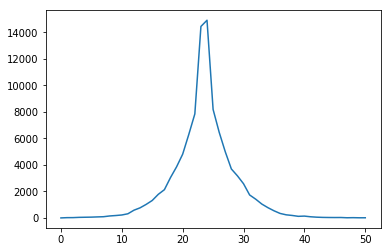

In [5]:
counts = np.bincount(peaks)
plt.plot(counts)

In [6]:
sample_weights = vae_resampler.get_sample_weights()

In [7]:
resampled = np.random.choice(a=peaks, size=VAE_USE_DATASET_SIZE, p=sample_weights)

After resampling, (and scaling by 10, since VAE_USE_DATA_SIZE is 1/10 the size of the full dataset), we see that the large spike in the middle has been distributed more evenly

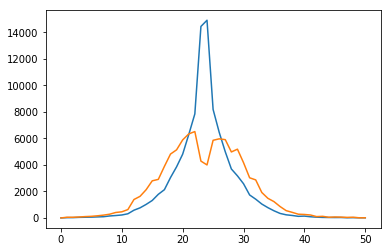

In [8]:
resamp_counts = np.bincount(resampled)*10
plt.plot(counts)
plt.plot(resamp_counts)

We use these sample_weights in the dataloader when sampling

In [9]:
sampler = WeightedRandomSampler(sample_weights, num_samples=VAE_USE_DATASET_SIZE, replacement=True)

In [10]:
batch_size = VAE_BATCH_SIZE
train_loader = DataLoader(all_data, batch_size=batch_size, sampler=sampler, num_workers=2)

Linear VAE gave us just as good results as convolutional, and it's simpler

In [11]:
# model = VAE(conv_sizes=[4,8,16,32], device=device).to(device)
model = VAELin(z_size=32, device=device).to(device)

summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Reshape-1                [-1, 12288]               0
            Linear-2                  [-1, 400]       4,915,600
              ReLU-3                  [-1, 400]               0
            Linear-4                   [-1, 32]          12,832
            Linear-5                   [-1, 32]          12,832
            Linear-6                  [-1, 400]          13,200
              ReLU-7                  [-1, 400]               0
            Linear-8                [-1, 12288]       4,927,488
           Reshape-9            [-1, 3, 64, 64]               0
          Sigmoid-10            [-1, 3, 64, 64]               0
Total params: 9,881,952
Trainable params: 9,881,952
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.39
Params size (MB): 37.70
Estima

In [12]:
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
num_epochs = 40

In [ ]:
for epoch in range(num_epochs):
    with tqdm_notebook(enumerate(train_loader), total=len(train_loader)) as progress:
        for batch_idx, train_batch in progress:
            train_batch = train_batch.to(device)
            optimizer.zero_grad()
            original, decoded, encoded, z, mu, logvar = model.forward(train_batch)
            
            loss, _, _ = model.loss(original, decoded, mu, logvar)
            losses.append(loss.detach().cpu().numpy())
            loss.backward()
            optimizer.step()
            progress.set_postfix(avg_loss=sum(losses[-(batch_idx+1):])/(batch_idx+1))

Training loss

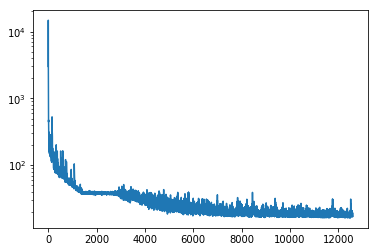

In [17]:
np_losses = np.array(losses)

plt.semilogy(np_losses)

Video of sample rollout compared to reconstruction

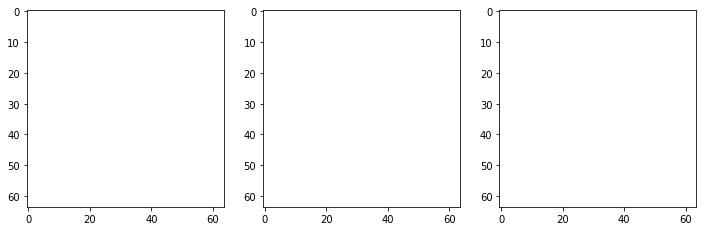

In [18]:
fig = plt.figure(figsize=(12,5))
ims = []
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
for i in range(1000):
    temp = all_data[i].cuda(device).reshape((1, 3, 64, 64))
    inim = temp[0].detach().cpu().numpy().transpose((1,2,0))
    outim = model.forward(temp)[1][0].detach().cpu().numpy().transpose((1,2,0))
    im1 = ax1.imshow(np.abs(inim), animated=True)
    im2 = ax2.imshow(np.abs(outim-inim), animated=True)
    im3 = ax3.imshow(np.abs(outim), animated=True)
    ims.append([im1, im2, im3])
anim = animation.ArtistAnimation(fig, ims, interval=20, blit=True)

In [19]:
vid = anim.to_html5_video()

In [20]:
HTML(vid)